# MNIST 데이터 준비

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH/FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

해당 데이터셋은 numpy 배열로, 데이터 직렬화를 위한 pickle을 이용하여 저장되어 있음

In [2]:
import pickle
import gzip

with gzip.open((PATH/ FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

각 이미지는 28x28 형태이고, 784(=28*28) 크기를 가진 하나의 행으로 저장되어 있음

이 이미지를 2d로 재구성해야함

(50000, 784)


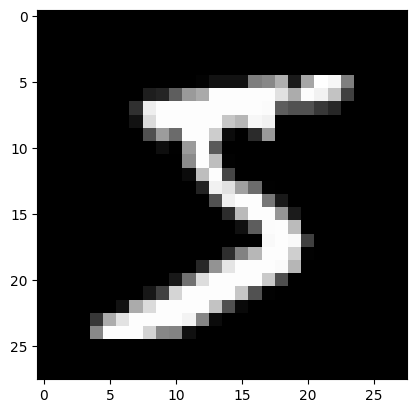

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

Pytorch는 numpy 배열보다는 torch.tensor를 이용하기에 변환해야함

In [4]:
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# Torch.nn 없이 밑바닥부터 신경망 만들기
pytorch는 랜덤 또는 0으로만 이루어진 텐서를 생성하는 메서드를 제공하고, 간단한 선형 모델의 weights와 bias를 생성하기 위해서 이것을 사용함.

pytorch에게 gradient가 필요하다고 알려주면 pytorch는 tensor에 행해지는 모든 연산을 기록하게 하고, 자동적으로 back-propagation 동안에 기울기를 계산 가능.

<div class="alert alert-info"><h4>Note</h4><p>`Xavier initialisation <http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf>`_
   기법을 이용하여 가중치를 초기화 합니다. (1/sqrt(n)을 곱해주는 것을 통해서 초기화).</p></div>

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드 캐스트 덧셈을 사용하기.

또한 activation function이 필요하므로 ``log_softmax``를 구현

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

``@``는 행렬 곱셈(matrix multiplication) 연산

하나의 batch 데이터에 대해서 함수를 호출할 것인데 이것은 하나의 포워드 전달(forward pass)임.

해당 단계에서 random weights로 시작했기 때문에 우리의 예측이 무작위 예측보다 나은 점이 없을 것.

In [7]:
bs = 64 # batch size

xb = x_train[0: bs] # x로부터 mini-batch 추출
preds = model(xb) # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.4415, -2.6756, -2.6453, -2.2980, -2.2491, -1.5321, -2.1321, -2.8138,
        -2.6444, -2.2879], grad_fn=<SelectBackward0>) torch.Size([64, 10])


``preds`` 텐서(tensor)는 텐서 이외에도 gradient function을 담고 있음.

나중에 이것을 backpropagation을 위해 사용할 것.

이제 loss function을 사용하기 위한 음의 로그 우도(negative log-likelihood)를 구현

In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

무작위 모델에 대한 손실을 점검 (나중에 역전파 이후 개선이 있는지 확인 가능)

In [9]:
yb = y_train[0: bs]
print(loss_func(preds, yb))

tensor(2.4047, grad_fn=<NegBackward0>)


또한 모델의 accuracy를 계산하기 위한 함수 구현

만약 큰 값의 인덱스가 target value와 동일시 예측 잘됨

In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

모델의 정확도 점검, 손실이 개선됨에 따라 정확도가 개선됐는지 확인 가능

In [11]:
print(accuracy(preds, yb))

tensor(0.0312)


training loop 실행
- 데이터의 미니배치를 선택 (``bs`` 크기)
- 모델을 이용하여 예측 수행
- 손실 계산
- ``loss.backward()`` 를 이용하여 모델의 기울기 업데이트, 이 경우에는, ``weights`` 와 ``bias``.

이 기울기들을 이용해서 weights와 bias를 업데이트. 이것을 ``torch.no_grad()`` context manager내에서 실행.
> 왜냐면 이런 실행이 다음 기울기의 계산에 기록되지 않길 원하기에

그리고 기울기를 0으로 설정, 다음 루프 준비하게 됨.
> 그렇지 않으면 기울기들은 일어난 모든 연산의 집계를 기록하게 됨

In [12]:
from IPython.core.debugger import set_trace

lr = 0.05
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // bs+1):
        # set_trace() # 매 단계마다 다양한 변수 값들을 점검
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

손실과 정확도를 이전 값들과 비교하면서 확인

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.6177, grad_fn=<NegBackward0>) tensor(0.8750)


# torch.nn.functional 사용하기
pytorch의 ``nn``클래스를 활용해서 코드 리팩토링.

코드를 짧게 만들기 가장 쉬운 단계는 활성화, 손실 함수를 ``toch.nn.functional``의 함수로 대체

만약 음의 로그 우도 손실과 log softmax 함수를 활용하는 경우, pytoch는 이 둘을 결합한 단일 함수인 ``F.cross_entrpy``를 제공
> 모델에서 활성화 함수를 제거할 수도 있음

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

더이상 ``model``함수에서 log_softmax를 호출하지 않음, 손실과 정확도가 이전과 동일한지 확인

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.6177, grad_fn=<NllLossBackward0>) tensor(0.8750)


# nn.Module을 이용해서 리팩토링하기
더 명확하고 간결한 훈련 루프를 위해 ``nn.Module``, ``nn.Parameter``를 사용
> ``nn.Module``의 subclass를 만들 것임.

    -> forward 단계에 대한 가중치, 절편, method등을 유지하는 클래스를 만듦.

In [24]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

함수를 사용하는 대신 object를 사용하기에 먼저 모델을 instantiate해야 함

In [25]:
model = Mnist_Logistic()

이제 이전과 동일한 방식으로 손실을 계산, 여기서 ``nn.Module`` 오브젝트들은 마치 함수처럼 사용됨

In [26]:
print(loss_func(model(xb), yb))

tensor(2.4258, grad_fn=<NllLossBackward0>)


이전에는 훈련 루프를 위해 이름 별로 각 매개변수(parameter)의 값을 업데이트하고 다음과 같이
각 매개 변수에 대한 기울기들을 개별적으로 수동으로 0으로 제거해야 했음:

::

  with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()


이제 model.parameters() 및 model.zero_grad()를 활용하여 이러한 단계를 더 간결하게
만들고, 특히 더 복잡한 모델에 대해서 일부 매개변수를 잊어 버리는 오류를 덜 발생시킬 수 있음:

::

  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()


이제 이것을 나중에 다시 실행할 수 있도록 ``fit`` 함수로 작은 훈련 루프를 감쌀 것.



In [28]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

손실이 줄었는지 확인

In [29]:
print(loss_func(model(xb), yb))

tensor(0.5262, grad_fn=<NllLossBackward0>)


# nn.Linear를 이용하여 리팩토링하기
계속해서 리팩토링 진행

``self.weights`` 및 ``self.bais``를 수동으로 정의 및 초기화하고,
``xb  @ self.weights + self.bias`` 를 계산하는 대신에,
위의 모든 것을 해줄 Pytorch 클래스인 `nn.Linear`_ 를 선형 레이어로 사용함.

pytorch에는 다양한 유형의 코드를 크게 단순화 할 수 있는 미리 정의된 레이어가 있고, 이는 종종 기존 속도보다 빠르게 함.

In [30]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.lin(xb)

이전과 같은 방식으로 모델을 인스턴스화하고 손실을 계산

In [31]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.4094, grad_fn=<NllLossBackward0>)


이전과 동일한 fit 함수 사용가능함

In [32]:
fit()
print(loss_func(model(xb), yb))

tensor(0.6465, grad_fn=<NllLossBackward0>)


# optim을 이용하여 리팩토링하기
Pytorch에는 다양한 최적화(optimization) 알고리즘을 가진 패키지인 ``torch.optim`` 도 있음.

각 매개변수를 수동으로 업데이트 하는 대신, 옵티마이저(optimizer)의 ``step`` 메소드를 사용하여
업데이트를 진행할 수 있음

이렇게 하면 이전에 수동으로 코딩한 최적화 단계를 대체 가능:

::

  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

대신에 이렇게:

::

  opt.step()
  opt.zero_grad()

(``optim.zero_grad()`` 는 기울기를 0으로 재설정, 다음 미니 배치에 대한
기울기를 계산하기 전에 호출 필요)


In [33]:
from torch import optim

모델과 옵티마이져를 만드는 작은 함수를 미리 정의

In [34]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3465, grad_fn=<NllLossBackward0>)
tensor(0.6231, grad_fn=<NllLossBackward0>)


# Dataset을 이용하여 리팩토링하기
PyTorch 에는 추상 Dataset 클래스가 있음.
Dataset 은 ``__len__`` 함수 (Python의 표준 ``len`` 함수에 의해 호출됨) 및
``__getitem__`` 함수를 가진 어떤 것이라도 될 수 있으며, 이 함수들을 인덱싱(indexing)하기 위한 방법으로 사용됨.

PyTorch 의 `TensorDataset <https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset>`_ 은 텐서를 감싸는(wrapping) Dataset임.

길이와 인덱싱 방식을 정의함으로써 텐서의 첫 번째 차원을 따라 반복, 인덱싱 및 슬라이스(slice)하는 방법도 제공.

이렇게하면 훈련 할 때 동일한 라인에서 독립(independent) 변수와 종속(dependent) 변수에 쉽게 액세스 할 수 있음.



In [36]:
from torch.utils.data import TensorDataset

x_train 및 y_train 모두 하나의 TensorDataset에 합쳐질 수 있음.

In [38]:
train_ds = TensorDataset(x_train, y_train)

이전에는 x 및 y 값의 미니 배치를 별도로 반복해야 했음:

::

    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]


이제 이 두 단계를 함께 수행 가능:

::

    xb,yb = train_ds[i*bs : i*bs+bs]

In [39]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.6308, grad_fn=<NllLossBackward0>)


# DataLoader 를 이용하여 리팩토링하기

Pytorch 의 ``DataLoader`` 는 배치 관리를 담당함. 모든 ``Dataset`` 으로부터 ``DataLoader`` 를 생성 가능.

``DataLoader`` 는 배치들에 대해서 반복하기 쉽게 만들어줌.

``train_ds[i*bs : i*bs+bs]`` 를 사용하는 대신, DataLoader 는 매 미니배치를 자동적으로 제공.



In [40]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

이전에는 루프가 다음과 같이 배치 (xb, yb)를 반복했음:

::

      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)

이제 (xb, yb)가 DataLoader 에서 자동으로 로드되므로 루프가 훨씬 깨끗해짐:

::

      for xb,yb in train_dl:
          pred = model(xb)



In [41]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.6343, grad_fn=<NllLossBackward0>)


Pytorch의 nn.Module, nn.Parameter, Dataset 및 DataLoader 덕분에 이제 훈련 루프가 훨씬 더 작아지고 이해하기 쉬워짐.

# 검증(validation) 추가하기
Overfitting을 확인하기 위해서 항상 validation set이 있어야 함.

훈련 데이터를 shuffling하는 것은 배치와 overfitting의 상관관계를 방지하기 위해 중요함. 반면에, validation loss는 검증 데이터를 섞지 않아도 동일함.

검증 데이터셋에 대한 배치 크기는 학습 데이터셋 배치 크기의 2배를 사용할 것임.
> backpropagation가 필요하지 않으므로 메모리를 덜 사용하기 때문(기울기 저장 불필요)

In [42]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

each epoch이 끝날 때 validation loss를 계산하고 print할 것임.

(훈련 전에 항상 ``model.train()`` 을 호출하고, 추론(inference) 전에 ``model.eval()``
을 호출,

이는 ``nn.BatchNorm2d`` 및 ``nn.Dropout`` 과 같은 레이어에서
이러한 다른 단계(훈련, 추론) 에 대한 적절한 동작이 일어나게 하기 위함.)


In [43]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3811)
1 tensor(0.3347)


# fit()과 get_data() 생성하기
작은 리팩토링 수행.

훈련 데이터셋과 검증 데이터셋 모두에 대한 손실을 계산하는 유사한 프로세스를 두 번 거치므로, 이를 하나의 배치에 대한 손실을 계산하는 자체 함수``loss_batch``로 만들 것임.

훈련 데이터셋에 대한 optmizer를 전달하고 이를 사용하여 역전파를 수행. 검증 데이터셋의 경우 optmizer를 전달하지 않으므로 메소드가 역전파를 수행하지 않음.

In [44]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit``은 모델을 훈련하고 각 에폭에 대한 훈련 및 검증 손실을 계산하는 작업 수행

In [46]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data``는 학습 및 검증 데이터 셋에 대한 dataloader를 출력함

In [47]:
def get_data(train_ds, valid_ds, bs):
    return(
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

dataloader를 가져오고 모델을 훈련하는 전체 프로세스 실행

In [48]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3845657294988632
1 0.3416427871465683


# CNN으로 넘어가기
3개의 컨볼루션 레이어로 신경망 구축

Pytorch의 사전 정의된 ``Conv2d``클래스를 컨볼루션 레이어로 사용함.

3개의 컨볼루션 레이어로 CNN을 정의, 각 컨볼루션 뒤에는 ReLU가 있고, 마지막으로 average pooling을 수행함.

(``view``는 PyTorch의 numpy ``reshape`` 버전임!)

In [49]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

`모멘텀(Momentum)` 은 이전 업데이트도 고려하고 일반적으로 더 빠른 훈련으로 이어지는 확률적 경사하강법(stochastic gradient descent)의 변형임.



In [50]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36917242314815524
1 0.2710613522529602


# nn.Sequential
`torch.nn`에는 코드를 간단히 할 수 있는 `Sequential`클래스가 있음.
> `Sequential` 객체는 그 안에 포함된 각 모듈을 순차적으로 실행함. 이것은 신경망을 작성하는 더 간단한 방법임.

<br>

이를 활용하려면 **사용자정의 레이어(custom layer)**를 쉽게 정의할 수 있어야 함.
> 예를 들면 pytorch에는 `view`레이어가 없으므로 우리의 신경망용으로 만들어야 함. 
<br>
> `Lambda`는 `Sequential`로 신경망을 정의할 때 사용할 수 있는 레이어를 생성할 것임.



In [51]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)

``Sequential`` 로 생성된 모델

In [52]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3293146110892296
1 0.24525599533319473


# DataLoader 감싸기
우리의 CNN은 상당히 간결하지만, MNIST에서만 작동함.
> 왜냐하면
> - 입력이 28\*28의 긴 벡터라고 가정.
> - 최종적으로 CNN 그리드 크기는 4\*4 라고 가정. (이것은 우리가 사용한 평균 풀링 커널 크기 때문.)

이 두 가지 가정을 제거하여 모델이 모든 2d 단일 채널(channel) 이미지에서 작동하도록 할 것임.

먼저 초기 Lambda 레이어를 제거하고 데이터 전처리를 제네레이터(generator)로 이동시킬 수 있음.

In [53]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield(self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

다음으로 ``nn.AvgPool2d`` 를 ``nn.AdaptiveAvgPool2d`` 로 대체하여 우리가 가진
*입력* 텐서가 아니라 원하는 *출력* 텐서의 크기를 정의할 수 있음.
> 결과적으로 우리 모델은 모든 크기의 입력과 함께 작동함.



In [54]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [55]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3647284022569656
1 0.27581741968393325


마치면서 
> 이 부분은 그대로 긁어옴
-----------------

이제 Pytorch를 사용하여 다양한 유형의 모델을 학습하는 데 사용할 수 있는 일반 데이터 파이프 라인과
훈련 루프가 있습니다.
이제 모델 학습이 얼마나 간단한지 확인하려면 `mnist_sample` 샘플 노트북을 살펴보세요.

물론 데이터 증강(data augmentation), 초매개변수 조정(hyperparameter tuning),
훈련과정 모니터링(monitoring training), 전이 학습(transfer learning) 등과 같이
추가하고 싶은 항목들이 많이 있을 것입니다.
이러한 기능들은 이 튜토리얼에 표시된 것과 동일한 설계 접근 방식을 사용하여 개발된 fastai 라이브러리에서
사용할 수 있으며, 모델을 더욱 발전시키려는 실무자에게 자연스러운 다음 단계를 제공합니다.

이 튜토리얼의 시작 부분에서 ``torch.nn``, ``torch.optim``, ``Dataset``,
그리고 ``DataLoader`` 의 각 예제를 통해 설명하겠다고 이야기했었습니다.
이제 위의 내용들을 요약해보겠습니다:

 - **torch.nn**

   + ``Module``: 함수처럼 동작하지만, 또한 상태(state) (예를 들어, 신경망의 레이어 가중치)를
     포함할 수 있는 호출 가능한 오브젝트를 생성합니다.
     이는 포함된 ``Parameter`` (들)가 어떤 것인지 알고, 모든 기울기를 0으로 설정하고 가중치
     업데이트 등을 위해 반복할 수 있습니다.
   + ``Parameter``: ``Module`` 에 역전파 동안 업데이트가 필요한 가중치가 있음을 알려주는
     텐서용 래퍼입니다. `requires_grad` 속성이 설정된 텐서만 업데이트 됩니다.
   + ``functional``: 활성화 함수, 손실 함수 등을 포함하는 모듈 (관례에 따라 일반적으로
     ``F`` 네임스페이스로 임포트 됩니다) 이고, 물론 컨볼루션 및 선형 레이어 등에 대해서
     상태를 저장하지않는(non-stateful) 버전의 레이어를 포함합니다.
 - ``torch.optim``: 역전파 단계에서 ``Parameter`` 의 가중치를 업데이트하는,
   ``SGD`` 와 같은 옵티마이저를 포함합니다.
 - ``Dataset``: ``TensorDataset`` 과 같이 Pytorch와 함께 제공되는 클래스를 포함하여 ``__len__`` 및
   ``__getitem__`` 이 있는 객체의 추상 인터페이스
 - ``DataLoader``: 모든 종류의 ``Dataset`` 을 기반으로 데이터의 배치들을 출력하는 반복자(iterator)를 생성합니다.